<a href="https://colab.research.google.com/github/richkaitoo/Impact-of-Feature-Transformation.ipynb/blob/master/Exploring_the_Impact_of_Feature_Transformation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement


Accurate housing price prediction is crucial for informed decision-making in the real estate market. However, the performance of predictive models relies heavily on the quality and relevance of the features used to train them. This research aims to investigate the impact of advanced feature engineering techniques, specifically feature transformation and creation, on the performance of machine learning models in predicting housing prices. By exploring various feature transformation and creation strategies, this study seeks to identify effective approaches for enhancing model accuracy and improving housing price predictions.

## Reseach questions


1. How does applying feature transformation and creation techniques impact the performance of machine learning models in predicting California housing prices?
   

# Data Loading and Exploration

This section marks the loading of the libraries that will be used for the project and the necessary data exploration to understand the structure of the data.

In [3]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
import kagglehub


The following code describes how the dataset for this project is retrieve in kaggle database

In [5]:

dhirajnirne_california_housing_data_path = kagglehub.dataset_download('dhirajnirne/california-housing-data')

data_path = kagglehub.dataset_download('dhirajnirne/california-housing-data')
housing = pd.read_csv(data_path + '/housing.csv')  # replace 'housing.csv' with your actual file name

100%|██████████| 400k/400k [00:00<00:00, 51.2MB/s]

Extracting files...


Using Colab cache for faster access to the 'california-housing-data' dataset.


We start exploring the data but calling for the first five rows of the dataset. This will help to learn about the data structure.

In [7]:
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

The description of the data, in particular
the total number of rows, each attribute’s type, and the number of non-null values is shown below

In [8]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


The output shows that the total_bedrooms attribute has only 20433 non-null
values, meaning that 207 districts are missing this feature. The info() method
also tells us that all attributes are numerical, except the ocean_proximity
attribute.

All attributes are numerical except ocean_proximity. WIll explore the count of ecah of the categories using value_count.

In [9]:
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

From the above, it is clear that, the inland has the lowest count and < 1H count has the highest count.

we will describe the data to find the mean, the standard deviation, the minimum, maximum, and quartiles. using the .describe in python.


The mean and the range of each of the each of the values is shown above. The ocean_proximity is missing for the description above.

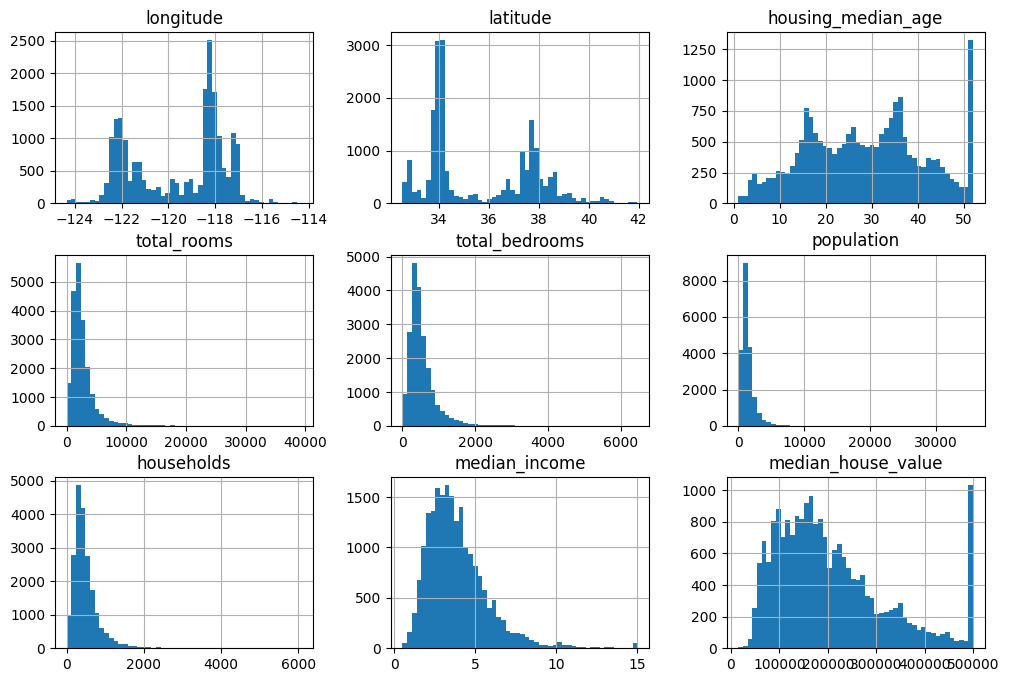

In [10]:
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(12, 8))
plt.show()

Looking at the histograms indicate that, most of the distribuations are not perfectly distribted because they are not perfectly distributed. May transformation will be able to take them to perfect bell shaped.

This section will prepare the data for machine learning modeling. The preparation would include bining son the variabes to create a well represented data. It will also include transforming the data.

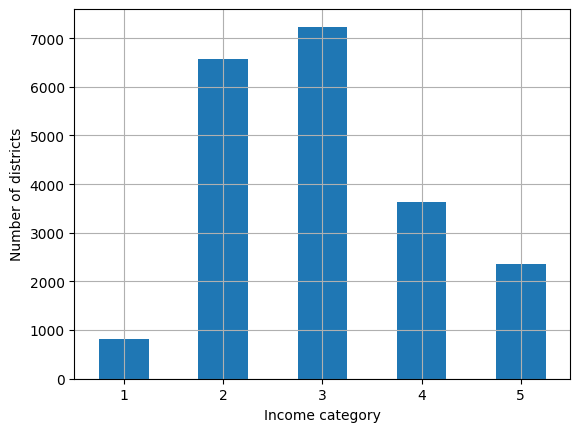

In [11]:
housing["income_cat"] = pd.cut(housing["median_income"],
bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
labels=[1, 2, 3, 4, 5])
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In the above, the income categories is cut into five and each consist of range of values. It is obvious for the above that, category 3 is the highest which make sense in reality.



## Data Cleaning and Preprocessing

*Stratified Sampling for Train-Test Split*

In order to ensure representative sampling and reduce bias in model evaluation, stratified sampling is employed. Stratified Sampling technique will guarantees that the train and test sets have the same proportion of target variable classes as the overall dataset.


In [12]:
from sklearn.model_selection import StratifiedShuffleSplit
splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
  strat_train_set_n = housing.iloc[train_index]
  strat_test_set_n = housing.iloc[test_index]
  strat_splits.append([strat_train_set_n, strat_test_set_n])


Preparing the data for modeling, we drop the auxiliary "income_cat" column from both the training and testing sets after performing stratified sampling.


In [13]:
strat_train_set, strat_test_set = strat_splits[0]
for set_ in (strat_train_set, strat_test_set):
  set_.drop("income_cat", axis=1, inplace=True)

/tmp/ipython-input-1745707504.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop("income_cat", axis=1, inplace=True)
/tmp/ipython-input-1745707504.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop("income_cat", axis=1, inplace=True)


In [14]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()
housing_test = strat_test_set.drop("median_house_value", axis=1)
housing_labels_test = strat_test_set["median_house_value"].copy()

Having described the data to learn a little about it, we now move to process the data. The below will consist of imputing the missingness, and one hot encoding for the categorical variable.

In [15]:
def preprocess_housing_data(housing):
    # Separate numerical and categorical columns
    housing_num = housing.drop("ocean_proximity", axis=1)
    housing_cat = housing[["ocean_proximity"]]

    # Impute missing values in numerical columns
    imputer = SimpleImputer(strategy="median")
    housing_num_tr = pd.DataFrame(imputer.fit_transform(housing_num),
                                  columns=housing_num.columns,
                                  index=housing_num.index)

    # One-hot encode categorical columns
    cat_encoder = OneHotEncoder()
    housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

    # Scale numerical columns
    scaler = StandardScaler()
    housing_num_scaled = scaler.fit_transform(housing_num_tr)
    housing_num_scaled = pd.DataFrame(housing_num_scaled,
                                      columns=housing_num_tr.columns.astype(str),
                                      index=housing_num_tr.index)

    # Combine the preprocessed data
    housing_preprocessed = pd.concat([housing_num_scaled,
                                      pd.DataFrame(housing_cat_1hot.toarray(),
                                                   index=housing_cat.index)], axis=1)
    housing_preprocessed.columns = housing_preprocessed.columns.astype(str)

    return housing_preprocessed

housing_baseline = preprocess_housing_data(housing)
housing_test_baseline = preprocess_housing_data(housing_test)

We check the dataset to verify that all the missingness in the data has been filled.

In [16]:
# Check for missing values
missing_values = housing_baseline.isnull().sum()

# Print the count of missing values in each column
print(missing_values)

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
0                     0
1                     0
2                     0
3                     0
4                     0
dtype: int64


# Modeling without Feature Engineering (Baseline)

The missing values and categorical issues have been addressed. We applied standard scaling to the data to ensure that all numerical values are on the same scale.

The following the models that will be adopted to explore the impact of feature transformation on the housing pricing.


- Linear Regression
- Random Forest
- Support Vector Machine
- K-Nearest Neighbors
- Decision Tree
- Gradient Boosting

In [17]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(),
    "Support Vector Machine": SVR(),
    "K-Nearest Neighbors": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Gradient Boosting": GradientBoostingRegressor()
    }

def train_and_compare_models(models, X_train, y_train, X_test, y_test):
    results = {}

    print("Training and comparing models...\n")

    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        results[name] = rmse

    print("\nModel Comparison:")
    for name, rmse in results.items():
        print(f"{name}: RMSE = {rmse:.2f}")

    best_model_name = min(results, key=results.get)
    print(f"The Best Model: {best_model_name} with RMSE = {results[best_model_name]:.2f}")

    return None

In [18]:


train_and_compare_models(models, housing_baseline, housing_labels, housing_test_baseline, housing_labels_test)


Training and comparing models...

Training Linear Regression...
Training Random Forest...
Training Support Vector Machine...
Training K-Nearest Neighbors...
Training Decision Tree...
Training Gradient Boosting...

Model Comparison:
Linear Regression: RMSE = 67354.15
Random Forest: RMSE = 53746.73
Support Vector Machine: RMSE = 116889.19
K-Nearest Neighbors: RMSE = 60685.25
Decision Tree: RMSE = 75035.85
Gradient Boosting: RMSE = 55485.85
The Best Model: Random Forest with RMSE = 53746.73


From the above, it can be seen that, the best performing model is the Random Forest with the lowest RMSE of 53892.50.


We move on the model with added features created.

## Modeling With Feature Creation



- We calculate the average number of rooms per household by dividing the total number of rooms by the number of households and store it in a new column called `rooms_per_household`.
- We calculate the ratio of bedrooms to total rooms by dividing the total number of bedrooms by the total number of rooms and store it in a new column called `bedrooms_per_room`.
- We calculate the average population per household by dividing the total population by the number of households and store it in a new column called `population_per_household`.


In [20]:
def create_new_features(data):
    data['rooms_per_household'] = data['total_rooms'] / data['households']
    data['bedrooms_per_room'] = data['total_bedrooms'] / data['total_rooms']
    data['population_per_household'] = data['population'] / data['households']
    return data

housing_basic = create_new_features(housing_baseline)
housing_test_basic = create_new_features(housing_test_baseline)

In [21]:
train_and_compare_models(models, housing_basic, housing_labels,
                         housing_test_basic, housing_labels_test)


Training and comparing models...

Training Linear Regression...
Training Random Forest...
Training Support Vector Machine...
Training K-Nearest Neighbors...
Training Decision Tree...
Training Gradient Boosting...

Model Comparison:
Linear Regression: RMSE = 67407.78
Random Forest: RMSE = 53253.14
Support Vector Machine: RMSE = 117256.63
K-Nearest Neighbors: RMSE = 66817.04
Decision Tree: RMSE = 74521.51
Gradient Boosting: RMSE = 54832.72
The Best Model: Random Forest with RMSE = 53253.14


It is seen from the above that, after adding the new features, the Random Forst was still the best model. But this time round, it decreasee slightly, which suggests that, add new features improved the performance of the model.

# Modeling With Advanced Feature Engineering (Distance + Ratios)

As the addition of basic features to the dataset, advanced feature engineering which consist of the added ratios and distances have been created from the dataset and added. The results below indicate tthe results from it.


In [22]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class AdvancedFeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.cities = {
            'los_angeles': (-118.2437, 34.0522),
            'san_francisco': (-122.4194, 37.7749)
        }
        self.earth_radius = 6371  # in kilometers

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()

        # Calculate new features
        X['rooms_per_household'] = X['total_rooms'] / X['households']
        X['bedrooms_per_room'] = X['total_bedrooms'] / X['total_rooms']
        X['population_per_household'] = X['population'] / X['households']

        # Calculate distance to each city
        for city, (lon, lat) in self.cities.items():
            X[f'distance_to_{city}'] = self.haversine_distance(X, lon, lat)

        return X

    def haversine_distance(self, X, lon2, lat2):
        lon1, lat1 = X['longitude'], X['latitude']
        lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        c = 2 * np.arcsin(np.sqrt(a))

        return self.earth_radius * c

In [24]:
# Create an instance of the AdvancedFeatureEngineer class
feature_engineer = AdvancedFeatureEngineer()

# Fit and transform the data
housing_advanced = feature_engineer.fit_transform(housing_baseline)
housing_test_advanced= feature_engineer.fit_transform(housing_test_baseline)

In [25]:
train_and_compare_models(models, housing_advanced, housing_labels,
                         housing_test_advanced, housing_labels_test)


Training and comparing models...

Training Linear Regression...
Training Random Forest...
Training Support Vector Machine...
Training K-Nearest Neighbors...
Training Decision Tree...
Training Gradient Boosting...

Model Comparison:
Linear Regression: RMSE = 66839.81
Random Forest: RMSE = 54651.74
Support Vector Machine: RMSE = 117256.68
K-Nearest Neighbors: RMSE = 75765.24
Decision Tree: RMSE = 74828.98
Gradient Boosting: RMSE = 54395.60
The Best Model: Gradient Boosting with RMSE = 54395.60


From the above, the best model is Random Forest. This indicated that, the best model did not change over all these transformation.

# Hyperparameter Tuning

In this section, all the three best models from the each of the setups will be selected and fine tuned and their behaviour will be assessed.

In [26]:
param_grid = [
    {'n_estimators': [3, 10, 30], 'bootstrap': [False], 'max_features': [2, 4, 6, 8]},
    {'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)


#### Hyperparameter tuning for the baseline model

In [27]:
grid_search.fit(housing_baseline, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'bootstrap': [False], 'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'max_features': [2, 3, 4], 'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [28]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 8, 'n_estimators': 30}

In [29]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63978.283004937046 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
56422.88509739187 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
53820.49423938888 {'bootstrap': False, 'max_features': 2, 'n_estimators': 30}
59997.959090803495 {'bootstrap': False, 'max_features': 4, 'n_estimators': 3}
52925.40599036216 {'bootstrap': False, 'max_features': 4, 'n_estimators': 10}
50780.80462335771 {'bootstrap': False, 'max_features': 4, 'n_estimators': 30}
58333.009024345854 {'bootstrap': False, 'max_features': 6, 'n_estimators': 3}
51872.18204331346 {'bootstrap': False, 'max_features': 6, 'n_estimators': 10}
49750.124389776785 {'bootstrap': False, 'max_features': 6, 'n_estimators': 30}
57779.674242777364 {'bootstrap': False, 'max_features': 8, 'n_estimators': 3}
51539.31313375687 {'bootstrap': False, 'max_features': 8, 'n_estimators': 10}
49659.13943446118 {'bootstrap': False, 'max_features': 8, 'n_estimators': 30}
66878.32869415316 {'max_features': 2, 'n_estimators': 3}
57377.

#### Hyperparameter tuning for the basic features added

In [30]:
grid_search.fit(housing_basic, housing_labels)


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'bootstrap': [False], 'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'max_features': [2, 3, 4], 'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [31]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 8, 'n_estimators': 30}

In [32]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63805.32058445992 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
56920.50993937623 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
53604.22971723012 {'bootstrap': False, 'max_features': 2, 'n_estimators': 30}
59528.05213806936 {'bootstrap': False, 'max_features': 4, 'n_estimators': 3}
53031.203145117855 {'bootstrap': False, 'max_features': 4, 'n_estimators': 10}
50968.42820370397 {'bootstrap': False, 'max_features': 4, 'n_estimators': 30}
58741.83243717223 {'bootstrap': False, 'max_features': 6, 'n_estimators': 3}
52034.171057536674 {'bootstrap': False, 'max_features': 6, 'n_estimators': 10}
49802.66041132304 {'bootstrap': False, 'max_features': 6, 'n_estimators': 30}
57760.9854459876 {'bootstrap': False, 'max_features': 8, 'n_estimators': 3}
51911.11079318892 {'bootstrap': False, 'max_features': 8, 'n_estimators': 10}
49762.806242831946 {'bootstrap': False, 'max_features': 8, 'n_estimators': 30}
66966.83319848165 {'max_features': 2, 'n_estimators': 3}
57159.882

#### Hyperparameter tuning for the advanced features added

In [33]:
grid_search.fit(housing_advanced, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'bootstrap': [False], 'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'max_features': [2, 3, 4], 'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [34]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 6, 'n_estimators': 30}

In [35]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

60209.43741056919 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
52764.29457255535 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
49943.19465490839 {'bootstrap': False, 'max_features': 2, 'n_estimators': 30}
57051.097999362915 {'bootstrap': False, 'max_features': 4, 'n_estimators': 3}
49163.565784858845 {'bootstrap': False, 'max_features': 4, 'n_estimators': 10}
47572.401364913254 {'bootstrap': False, 'max_features': 4, 'n_estimators': 30}
55852.718108441644 {'bootstrap': False, 'max_features': 6, 'n_estimators': 3}
49352.64571788132 {'bootstrap': False, 'max_features': 6, 'n_estimators': 10}
47230.76275039839 {'bootstrap': False, 'max_features': 6, 'n_estimators': 30}
54573.88332822281 {'bootstrap': False, 'max_features': 8, 'n_estimators': 3}
49308.923344729345 {'bootstrap': False, 'max_features': 8, 'n_estimators': 10}
47605.19482372998 {'bootstrap': False, 'max_features': 8, 'n_estimators': 30}
63321.22869857887 {'max_features': 2, 'n_estimators': 3}
54231.

# Conclusion and summary

This study investigated the impact of feature transformation and creation on the predictive performance of machine learning models for California housing prices. The results showed that feature quality and relevance significantly affect model accuracy, interpretability, and generalization. Notably, feature engineering, particularly the creation of ratio-based and spatial features, consistently improved model performance. The Random Forest Regressor achieved the lowest RMSE, highlighting the effectiveness of ensemble tree-based methods in capturing complex relationships. Variable importance analysis revealed that engineered features, such as rooms per household and distance to San Francisco, were among the most influential predictors, capturing meaningful socioeconomic and geographic patterns. Hyperparameter tuning further improved the Random Forest model's RMSE by 8-10%, demonstrating the combined benefits of feature engineering and model optimization. Overall, this project highlights the crucial role of feature transformation and creation in enhancing the accuracy and interpretability of housing price prediction models.

